In [1]:
import scipy
import scipy.misc
import numpy as np
import random
import pandas as pd
import gym
from tqdm import tqdm
from tqdm import tqdm_notebook
import os
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lasagne
import theano.tensor as T
import theano

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
class ATARI_wrapper():
    def __init__(self, gamename = "Enduro-v0"):
        self.state_size = (105, 80)
        self.game_title = gamename
        self.actions = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        grayimage = np.mean(state, axis = 2)
        downscale = self.downscale2x(grayimage)
        norm = (downscale - 128.0) / 128.0
        return norm
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3
    
    def downscale2x(self, image):
        image00 = image[0::2, 0::2]
        image01 = image[0::2, 1::2]
        image10 = image[1::2, 0::2]
        image11 = image[1::2, 1::2]
        return (image00 + image01 + image10 + image11) / 4

In [5]:
class LunarLanding_wrapper():
    def __init__(self):
        self.state_size = (1, 8)
        self.game_title = "LunarLander-v2"
        self.actions = ["DO_NOTHING", "FIRE_LEFT", "FIRE_MAIN", "FIRE_RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [6]:
class CartPole_wrapper():
    def __init__(self):
        self.state_size = (1, 4)
        self.game_title = "CartPole-v0"
        self.actions = ["LEFT", "RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [7]:
class AVQ_nn():
    def __init__(self, channels_number = 4, image_shape = (1, 8), n_actions = 4, grad_clipping = 10, lr = 0.0001, 
                 encodeunits = 10, encodenoise = 0.1, aelosscoef = 0.1, regaelosscoef = 2.0, 
                 explosscoef = 0.1, h = 50, alpha = 25):
        self.input_var = T.tensor4('statebatch')
        self.targetQ = T.fvector('targetQ')
        self.targetE = T.fvector('targetE')
        self.actions = T.ivector('actions')
        self.newstates = T.tensor4("newstatebatch")
        self.actions_onehot = T.extra_ops.to_one_hot(self.actions, n_actions, dtype=np.float32)
        
        self.aelosscoef = aelosscoef
        self.regaelosscoef = regaelosscoef
        self.explosscoef = explosscoef
        self.n_actions = n_actions
        self.build_network(channels_number, image_shape, encodeunits, encodenoise)
        self.build_AVQ(grad_clipping, lr, h, alpha)
        self.compile_network()
        
    def build_network(self, channels_number, image_shape, encodeunits, encodenoise):
        self.l1 = lasagne.layers.InputLayer(shape=(None, channels_number, image_shape[0], image_shape[1]), 
                                            input_var = self.input_var)
        self.l2 = lasagne.layers.DenseLayer(self.l1, 60, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.l3 = lasagne.layers.DenseLayer(self.l2, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.outlayer = lasagne.layers.DenseLayer(self.l3, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.encode = lasagne.layers.DenseLayer(self.outlayer, encodeunits, nonlinearity=lasagne.nonlinearities.sigmoid)
        self.encodenoise = lasagne.layers.GaussianNoiseLayer(self.encode, sigma = encodenoise)
        self.le3 = lasagne.layers.DenseLayer(self.encodenoise, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.le2 = lasagne.layers.DenseLayer(self.le3, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.le1 = lasagne.layers.DenseLayer(self.le2, 60, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.le0 = lasagne.layers.DenseLayer(self.le1, channels_number * image_shape[0] * image_shape[1])
        self.l_aeout = lasagne.layers.ReshapeLayer(self.le0, shape=(-1, channels_number, image_shape[0], image_shape[1]))
    
    def build_AVQ(self, grad_clipping, lr, h, alpha):
        self.l_advantage = lasagne.layers.DenseLayer(self.outlayer, self.n_actions)
        self.l_value = lasagne.layers.DenseLayer(self.outlayer, 1)
        self.l_varq = lasagne.layers.DenseLayer(self.outlayer, self.n_actions, nonlinearity=lasagne.nonlinearities.softplus)
        self.l_exp_out = lasagne.layers.DenseLayer(self.outlayer, self.n_actions)
        
        self.advantage, self.value, self.ae_out, self.enc, self.varq, self.exp_out = \
            lasagne.layers.get_output([self.l_advantage, self.l_value, self.l_aeout, self.encode, self.l_varq, self.l_exp_out])
        
        self.average_advantage = T.mean(self.advantage, keepdims = True, axis = 1)
        
#        self.Qout = self.advantage + self.value - self.average_advantage
#-----
        self.Q = self.advantage
        self.predict = T.argmax(self.Q, axis = 1)
        
        self.actions_onehot = T.extra_ops.to_one_hot(self.actions, self.n_actions, dtype=np.float32)
        
        self.E = self.exp_out
        self.Epredict = T.argmax(self.E, axis = 1)
        
        self.E0 = T.sum(self.E * self.actions_onehot, axis = 1)
        
        self.Q0 = T.sum(self.Q * self.actions_onehot, axis = 1)
        self.varQ0 = T.sum(self.varq * self.actions_onehot, axis = 1)
        
        self.Q1 = self.Q0 + (self.targetQ - self.Q0) / (h + 1)
        self.varQ1 = (h * (alpha - 1)) / ((h + 1) * (alpha - 0.5)) * \
                     (self.varQ0 + T.sqr(self.targetQ - self.Q0) / (2 * (h+1) * (alpha - 1)))
        
        self.exp_error = T.mean(T.sqr(self.targetE - self.E0))
        self.td_error = T.mean(T.sqr(self.Q1 - self.Q0))
        self.var_error = T.mean(T.sqr(self.varQ1 - self.varQ0))
        self.regae_error = 0.25 - T.mean(T.sqr(self.enc - 0.5))
        self.ae_error = T.mean(T.sqr(self.ae_out - self.input_var))
        
        self.loss = self.ae_error * self.aelosscoef + self.regaelosscoef * self.regae_error + self.td_error + self.var_error + self.explosscoef * self.exp_error
        params = self.get_all_params()
        self.all_grads = T.grad(self.loss, params)
        self.scaled_grads = lasagne.updates.total_norm_constraint(self.all_grads, grad_clipping)
        self.updates = lasagne.updates.adam(self.scaled_grads, params, learning_rate=lr)

        enc_layers = [self.l2, self.l3, self.outlayer, self.encode, self.le3, self.le2, self.le1, self.le0]
        enc_params = [l.W for l in enc_layers] + [l.b for l in enc_layers]
        self.enc_grads = T.grad(self.ae_error, enc_params)
        self.enc_scaled_grads = lasagne.updates.total_norm_constraint(self.enc_grads, grad_clipping)
        self.enc_updates = lasagne.updates.adam(self.enc_scaled_grads, enc_params, learning_rate=lr)
        
    def compile_network(self):
        self.Qout_fn = theano.function([self.input_var], self.Q)
        self.actionpred_fn = theano.function([self.input_var], self.predict)
        self.full_train_fn = theano.function([self.input_var, self.targetQ, self.targetE, self.actions], [self.ae_error, self.td_error], updates = self.updates)
        self.train_encoder = theano.function([self.input_var], self.ae_error, updates = self.enc_updates)
        self.get_encode = theano.function([self.input_var], [self.enc, self.regae_error])
        self.var_fn = theano.function([self.input_var], self.varq)
        
        self.Eout_fn = theano.function([self.input_var], self.E)
        self.Eactionpred_fn = theano.function([self.input_var], self.Epredict)
        
    def get_all_params(self):
#        return lasagne.layers.get_all_params([self.l_advantage, self.l_value], trainable = True)
        return lasagne.layers.get_all_params(self.l_advantage, trainable = True)
    
    def get_all_params_values(self):
#        return lasagne.layers.get_all_param_values([self.l_advantage, self.l_value], trainable = True)
        return lasagne.layers.get_all_param_values(self.l_advantage, trainable = True)
    
    def set_all_params_values(self, values):
#        return lasagne.layers.set_all_param_values([self.l_advantage, self.l_value], values, trainable = True)
        return lasagne.layers.set_all_param_values(self.l_advantage, values, trainable = True)

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self, size):
        size = min(size, len(self.buffer))
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5])

In [9]:
class window_aggregator():
    def __init__(self, window_length, state_shape):
        self.state_shape = state_shape
        self.window_length = window_length
        
        assert len(self.state_shape) == 2
        assert self.window_length >= 1
        
        self.start_aggregator_shape = (window_length, state_shape[0], state_shape[1])
                                             
        self.aggregator = np.zeros(self.start_aggregator_shape)
        
    def reset(self):
        self.aggregator = np.zeros(self.start_aggregator_shape)
                                       
    def add_state(self, state):
        state = np.expand_dims(state, 0)
        self.aggregator = np.append(self.aggregator, state, axis = 0)
    
    def get_window(self):
        return self.aggregator[-self.window_length:,:,:]                                                                           

In [10]:
class egreedy_agent():
    def __init__(self, n_actions, actionpred_fn, startE = 1, endE = 0.1, anneling_steps = 50000):
        self.startE = startE
        self.endE = endE
        self.anneling_steps = anneling_steps
        self.stepE = (self.startE - self.endE) / self.anneling_steps
        self.n_actions = n_actions
        self.actionpred_fn = actionpred_fn
    
    def choose_action(self, state, current_step):
        if current_step > self.anneling_steps:
            epsilon = self.endE
        else:
            epsilon = self.startE - self.stepE * current_step
        
        if np.random.rand(1) < epsilon:
            a = np.random.randint(0, self.n_actions)
        else:
            a = self.actionpred_fn(np.expand_dims(state, axis = 0))[0]
            
        return a

In [11]:
class boltzman_agent:
    def __init__(self, n_actions, Qout_fn, startT = 1000, endT = 0.1, anneling_steps = 50000):
        self.startT = startT
        self.endT = endT
        self.anneling_steps = anneling_steps
        self.logstep = (np.log(startT) - np.log(endT)) / anneling_steps
        self.n_actions = n_actions
        self.Qout_fn = Qout_fn
    
    def choose_action(self, state, current_step):
        scores = self.Qout_fn(np.expand_dims(state, axis = 0))[0]
        if current_step > self.anneling_steps:
            exponents = np.exp((scores - np.max(scores)) / self.endT)
        else:
            current_temp = self.startT / np.exp(self.logstep * current_step)
            exponents = np.exp((scores - np.max(scores)) / current_temp)
        probs = exponents / np.sum(exponents)
        return np.random.choice(self.n_actions, p = probs)

In [12]:
class combined_agent:
    def __init__(self, n_actions, actionpred_fn, Eactionpred_fn, startE = 1, endE = 0.1, anneling_steps = 50000):
        self.startE = startE
        self.endE = endE
        self.anneling_steps = anneling_steps
        self.stepE = (self.startE - self.endE) / self.anneling_steps
        self.n_actions = n_actions
        self.actionpred_fn = actionpred_fn
        self.Eactionpred_fn = Eactionpred_fn
    
    def choose_action(self, state, current_step):
        if current_step > self.anneling_steps:
            epsilon = self.endE
        else:
            epsilon = self.startE - self.stepE * current_step
        
        if np.random.rand(1) < epsilon:
            a = self.Eactionpred_fn(np.expand_dims(state, axis = 0))[0]
        else:
            a = self.actionpred_fn(np.expand_dims(state, axis = 0))[0]
            
        return a

In [13]:
class DDQL():
    def __init__(self, lparams, env, agent = {"agent":"egreedy", "params":{}}):
        self.grad_clip = lparams["grad_clipping"]
        self.lr = lparams["learning_rate"]
        self.window_size = lparams["window_size"]
        self.encode_unitnum = lparams["encode_unitnum"]
        self.encode_noise = lparams["encode_noise"]
        self.encode_reward_multiplier = lparams["encode_reward_multiplier"]
        self.batch_size = lparams["batch_size"]
        self.gamma = lparams["gamma"]
        self.egamma = lparams["egamma"]
        self.aelosscoef = lparams["aelosscoef"]
        self.regaelosscoef = lparams["regaelosscoef"]
        self.explosscoef = lparams["explosscoef"]
        self.h = lparams["lambda"]
        self.alpha = lparams["alpha"]
        self.MQN_updatefreq = lparams["MQN_updatefreq"]
        self.TQN_updatefreq = lparams["TQN_updatefreq"]
        self.TQN_updaterate = lparams["TQN_updaterate"]
        self.print_freq = lparams["print_freq"]
        self.pretrain_steps = lparams["pretrain_steps"]
        self.buffer_size = lparams["buffer_size"]
        self.pretrain_over = False

        self.env = env
        
        AVQ_params = [self.window_size, self.env.state_size, self.env.n_actions, self.grad_clip, 
                      self.lr, self.encode_unitnum, self.encode_noise, self.aelosscoef, self.regaelosscoef, 
                      self.explosscoef, self.h, self.alpha]
        self.mainQN = AVQ_nn(*AVQ_params)
        self.targetQN = AVQ_nn(*AVQ_params)

        self.lList = []
        self.rList = []
        self.aeList = []
        self.encode_counts = defaultdict(int)
        self.total_steps = 0
        
        self.window = window_aggregator(self.window_size, self.env.state_size)
        self.experience_storage = experience_buffer(self.buffer_size)
        self.agent = self.getAgent(agent["agent"], agent["params"])
            
    def getAgent(self, agent, agentparams):
        if agent == "egreedy":
            agent = egreedy_agent(self.env.n_actions, self.mainQN.actionpred_fn, **agentparams)
        elif agent == "boltzman":
            agent = boltzman_agent(self.env.n_actions, self.mainQN.Qout_fn, **agentparams)
        elif agent == "combined":
            agent = combined_agent(self.env.n_actions, self.mainQN.actionpred_fn, self.mainQN.Eactionpred_fn, **agentparams)
        else:
            raise ValueError("Unknown agent")
            
        return agent
            
    def updateTarget(self, completeupdate = False):
        if completeupdate:
            self.targetQN.set_all_params_values(self.mainQN.get_all_params_values())
        else:
            targetparams = self.targetQN.get_all_params_values()
            mainparams = self.mainQN.get_all_params_values()
            ur = self.TQN_updaterate
        
            assert len(targetparams) == len(mainparams)
            for k in range(0, len(targetparams)):
                targetparams[k] = targetparams[k] * (1.0 - ur) + mainparams[k] * ur
        
            self.targetQN.set_all_params_values(targetparams)
            
    def train(self, num_episodes, frame_limit, render = True):
        self.updateTarget(True)
        self.window.reset()
        
        for episode_num in tqdm_notebook(range(num_episodes), desc = "RL train"):
            state = self.env.make_reset()
            self.window.add_state(state)
            window_state = self.window.get_window()
            episode_rewards = np.zeros(frame_limit)
            episode_aeerrors = np.array([])
            
            for iteration in xrange(0, frame_limit):
                action = self.agent.choose_action(window_state, self.total_steps)
                new_state, reward, gameover, _ = self.env.make_step(action, render)
                self.window.add_state(new_state)
                new_window_state = self.window.get_window()
                experience = np.reshape(np.array([window_state, action, reward, new_window_state, gameover]),[1,5])
                self.experience_storage.add(experience)
                episode_rewards[iteration] = reward
                
                if self.pretrain_over:
                    self.total_steps += 1
                
                    if self.total_steps % (self.TQN_updatefreq) == 0:
                        self.updateTarget()
                
                    if self.total_steps % (self.MQN_updatefreq) == 0:
                        train_batch = self.experience_storage.sample(self.batch_size)
                        old_state_batch = np.stack(train_batch[:,0])
                        new_state_batch = np.stack(train_batch[:,3])
                        action_vector = (train_batch[:,1]).astype(np.int32)
                        end_multiplier = -(train_batch[:,4] - 1)
                        rewards_vector = train_batch[:,2]
                        
                        encodes, reg_errors = self.mainQN.get_encode(old_state_batch)
                        encodes = ["".join([str(k) for k in encode]) for encode in (encodes > 0.5).astype(int)]
                        for encode in encodes:
                            self.encode_counts[encode] += 1
                        encode_rewards = self.encode_reward_multiplier / np.sqrt(np.array([self.encode_counts[encode] for encode in encodes]))
                        
                        E1 = self.mainQN.Eactionpred_fn(new_state_batch)
                        E2 = self.targetQN.Eout_fn(new_state_batch)
                        doubleE = E2[range(self.batch_size), E1]
                        var1 = self.mainQN.var_fn(old_state_batch)
                        doublevar = var1[range(self.batch_size), E1]
                        exp_rewards_vector = doublevar + 0.01 * encode_rewards
                        
                        targetE = (exp_rewards_vector + (self.egamma * doubleE * end_multiplier)).astype(np.float32)
                        
                        Q1 = self.mainQN.actionpred_fn(new_state_batch)
                        Q2 = self.targetQN.Qout_fn(new_state_batch)
                        doubleQ = Q2[range(self.batch_size), Q1]
                        targetQ = (rewards_vector + (self.gamma * doubleQ * end_multiplier)).astype(np.float32)
                        
                        aeerror, tderror = self.mainQN.full_train_fn(old_state_batch, targetQ, targetE, action_vector)
                        episode_aeerrors = np.append(episode_aeerrors, aeerror)
                else:
                    train_batch = self.experience_storage.sample(self.batch_size)
                    old_state_batch = np.stack(train_batch[:,0])
                    new_state_batch = np.stack(train_batch[:,3])
                    action_vector = (train_batch[:,1]).astype(np.int32)
                    aeerror1 = self.mainQN.train_encoder(old_state_batch)
                    aeerror2 = self.mainQN.train_encoder(new_state_batch)
                    episode_aeerrors = np.append(episode_aeerrors, (aeerror1 + aeerror2)/2)
                    
                    self.pretrain_steps -= 1;
                    if self.pretrain_steps <= 0:
                        self.pretrain_over = True
                        
                state = new_state
                window_state = new_window_state
            
                if gameover:
                    self.window.reset()
                    break
    
            total_reward = np.sum(episode_rewards)
            total_aeerror = np.mean(episode_aeerrors)
            self.lList.append(iteration)
            self.rList.append(total_reward)
            self.aeList.append(total_aeerror)
            if len(self.rList) % self.print_freq == 0:
                tqdm.write(" ".join(["========= Episode", str(episode_num), "================================================"]))
                tqdm.write(" ".join(["Total steps:", str(self.total_steps)]))
                tqdm.write(" ".join(["Episode rewards, last 10:", str(self.rList[-10:])]))
                tqdm.write(" ".join(["Mean over last", str(self.print_freq), "episodes:", str(np.mean(self.rList[-self.print_freq:]))]))
                tqdm.write(" ".join(["Episode lengths, last 10:", str(self.lList[-10:])]))
                tqdm.write(" ".join(["AEerror, mean over last 10:", str(np.mean(self.aeList[-10:]))]))
                tqdm.write("===================================================================" + "=" * len(str(episode_num)))

In [14]:
def plot_rewards(ddqlmodel, meanwindow = 250):
    rlist = [ddqlmodel.rList[0]] * meanwindow + ddqlmodel.rList
    x = np.cumsum(ddqlmodel.lList)
    y = [np.mean(rlist[k:k+meanwindow]) for k in range(len(rlist) - meanwindow)]
    plt.plot(x, y)

In [15]:
ll_env = LunarLanding_wrapper()
#cp_env = CartPole_wrapper()

[2017-05-15 20:57:09,170] Making new env: LunarLander-v2


In [16]:
lparams = {"grad_clipping" : 50,
           "learning_rate" : 0.005,
           "window_size" : 3,
           "encode_unitnum": 10,
           "encode_noise": 0.05,
           "encode_reward_multiplier": 10.0,
           "batch_size" : 8,
           "buffer_size" : 128,
           "aelosscoef" : 0.1,
           "regaelosscoef" : 2.0,
           "explosscoef" : 0.1,
           "gamma" : 0.98,
           "egamma" : 0.01,
           "lambda": 4,
           "alpha": 2,
           "MQN_updatefreq" : 1,
           "TQN_updatefreq" : 4,
           "TQN_updaterate" : 0.2,
           "print_freq" : 125,
           "pretrain_steps" : 500,
           "render" : False}

In [17]:
egreedyagentinfo = {"agent" : "egreedy",
                    "params" : {"startE": 0.5,
                                "endE" : 0.06,
                                "anneling_steps":10000}}

In [18]:
boltzmanagentinfo = {"agent" : "boltzman",
                     "params" : {"startT": 10,
                                 "endT" : 1,
                                 "anneling_steps":10000}}

In [19]:
combinedagentinfo = {"agent" : "combined",
                     "params" : {"startE": 0.5,
                                 "endE" : 0.1,
                                 "anneling_steps":10000}}

In [20]:
def produce_experiment(ddql, ddql_init_params, ddql_train_params, experiment_num = 5):
    ddql_list = [ddql(**ddql_init_params) for k in range(experiment_num)]
    
    for k in range(experiment_num):
        ddql_list[k].train(**ddql_train_params)
        
    return ddql_list

In [21]:
ddql_combined_params = {"lparams":lparams, "env":ll_env, "agent":combinedagentinfo}
ddql_egreedy_params = {"lparams":lparams, "env":ll_env, "agent":egreedyagentinfo}

ddql_train_params = {"num_episodes":1250, "frame_limit":200, "render":False}

In [22]:
res = produce_experiment(DDQL, ddql_combined_params, ddql_train_params, 10)

========= Episode 499 ================================================
Total steps: 34662
Episode rewards, last 10: [-222.95289733383066, -171.85998432979778, -197.84107840139239, -190.51407165642013, -122.26801588789567, -179.17098381191983, -157.18672506602263, -123.24954437394095, -144.20315536237689, -143.88341384930749]
Mean over last 500 episodes: -271.919246031
Episode lengths, last 10: [67, 78, 99, 69, 92, 81, 58, 97, 95, 89]
AEerror, mean over last 10: 0.465327530893
========= Episode 999 ================================================
Total steps: 72931
Episode rewards, last 10: [-184.38393874027813, -205.55096416410498, -145.6294956834285, -239.34368808406745, -186.01719372680557, -214.69560664824752, -220.67263246639567, -205.30533139082613, -126.25284497540883, -152.55186133905283]
Mean over last 500 episodes: -217.383480529
Episode lengths, last 10: [60, 65, 61, 70, 71, 63, 87, 72, 57, 61]
AEerror, mean over last 10: 0.528660151214
========= Episode 1499 ================

In [23]:
def plot_results(ddql_res, window = 100, std_coef = 0.2, results_over = 1000):
    res_lists = [k.rList for k in ddql_res]
    res_lists = np.array(res_lists)
    pd.DataFrame(data = res_lists)
    mean = res_lists.mean(axis = 0)
    std = res_lists.std(axis = 0)
    rol_mean = np.nan_to_num(pd.Series(mean).rolling(window = window).mean())[window:]
    rol_std = np.nan_to_num(pd.Series(std).rolling(window = window).mean())[window:]
    plt.figure()
    index = np.arange(window, len(rol_mean) + window)
    plt.plot(index, rol_mean)
    plt.fill_between(index, rol_mean-std_coef*rol_std, rol_mean+std_coef*rol_std, color='b', alpha=0.1)
    return max(rol_mean[window:results_over]), rol_mean[window:results_over].mean(), pd.DataFrame(data = res_lists)

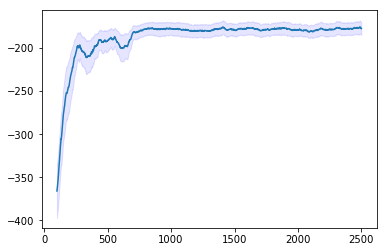

In [27]:
comb_max, comb_auc, comb_df = plot_results(res, 100, 0.2)
plt.savefig("comb_ll.png")

In [25]:
print comb_max, comb_auc

-176.693954741 -189.995532945


In [26]:
comb_df.to_csv("comb.csv")

In [32]:
comb_df[[i for i in range(0, 1250)]].to_csv("comb.csv")